In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Exploratory Data Analysis and Model Building

In [109]:
df = pd.read_csv('static/2023_APR.csv', index_col='_id')
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,block,rooms,avg_storey,timeseries_month,year,original_street_name,region,position
_id,,,,,,,,,,,,,,,,,,
143402,Ang Mo Kio,2 Room,Improved,44.0,Ang Mo Kio Avenue 3,298000.0,4,53.750000,1978,07 To 09,314,2.0,8.0,2023-04-01,2023,Ang Mo Kio Ave 3,North-East,"1.36622707120636,103.850085858983 560314"
143405,Ang Mo Kio,2 Room,Improved,44.0,Ang Mo Kio Avenue 8,305000.0,4,56.166667,1980,07 To 09,510,2.0,8.0,2023-04-01,2023,Ang Mo Kio Ave 8,North-East,"1.37340092645025,103.849073244454 560510"
143421,Ang Mo Kio,3 Room,New Generation,82.0,Ang Mo Kio Avenue 1,372000.0,4,53.333333,1977,01 To 03,220,3.0,2.0,2023-04-01,2023,Ang Mo Kio Ave 1,North-East,"1.36558833593063,103.840518883254 560220"
143422,Ang Mo Kio,3 Room,Model A,70.0,Ang Mo Kio Avenue 1,585000.0,4,88.416667,2012,19 To 21,308B,3.0,20.0,2023-04-01,2023,Ang Mo Kio Ave 1,North-East,"1.3652661423815,103.844538059044 562308"
143464,Ang Mo Kio,3 Room,New Generation,68.0,Ang Mo Kio Avenue 10,388000.0,4,56.833333,1981,01 To 03,542,3.0,2.0,2023-04-01,2023,Ang Mo Kio Ave 10,North-East,"1.37473841331656,103.855876768354 560542"


## 1. EDA
### Summary of actions before training

1. Checking for collinearity
2. Preprocessing (label and mean encoding)
3. Feature selection (KBest, Lasso regression)
4. Model selection
5. Hyperparameter tuning 

### 1.1 Checking for collinearity among numerical features
* There is strong collinearity between floor_area_sqm and rooms (0.86)
* Even much so higher than its correlation with output (resale price)

<Axes: >

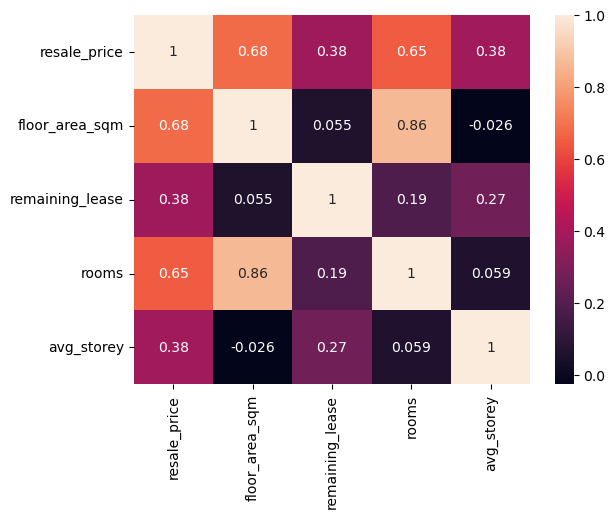

In [110]:
impt_features = df[['resale_price', 'floor_area_sqm', 'remaining_lease', 'rooms', 'avg_storey']]
sns.heatmap(impt_features.corr(), annot=True)

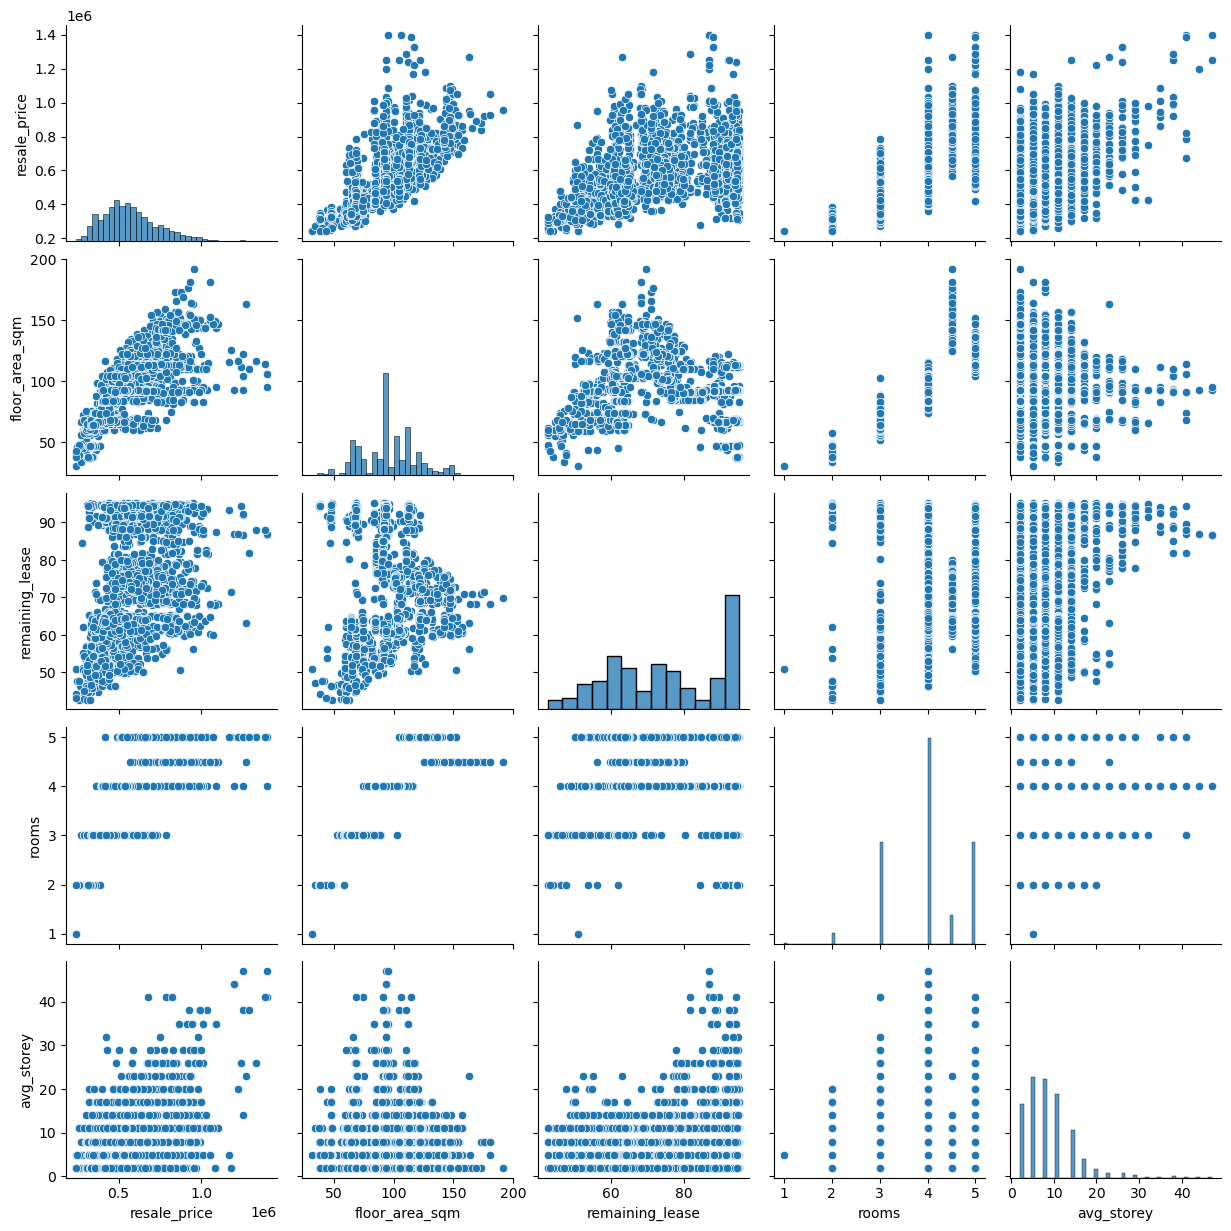

In [111]:
sns.pairplot(impt_features)
plt.show()

### Remove null values

In [112]:
display(df.isna().sum())
df.dropna(axis=1, inplace=True)

town                    0
flat_type               0
flat_model              0
floor_area_sqm          0
street_name             0
resale_price            0
month                   0
remaining_lease         0
lease_commence_date     0
storey_range            0
block                   0
rooms                   0
avg_storey              0
timeseries_month        0
year                    0
original_street_name    0
region                  0
position                7
dtype: int64

### 1.2 Preprocessing (label and mean encoding)
* There will certainly be variation across different geographical areas in Singapore, due to a non-exhaustive number of factors:
    * location
    * infrastructure and amenitites
    * affluent / less affluent neighbourhoods
    * supply and demand
    * market speculation  
&nbsp;
* Thus, we will perform mean encoding (resale_price) onto the various geographical areas (town and region)

In [113]:
town_mean_dict = df.groupby('town')['resale_price'].mean(numeric_only=True).to_dict()
region_mean_dict = df.groupby('region')['resale_price'].mean(numeric_only=True)
town_mean_price = df.loc[:,'town'].map(town_mean_dict)
region_mean_price = df.loc[:,'region'].map(region_mean_dict)
df = pd.concat([impt_features, town_mean_price, region_mean_price], axis =1)
df.head()

,resale_price,floor_area_sqm,remaining_lease,rooms,avg_storey,town,region
_id,,,,,,,
143402,298000.0,44.0,53.750000,2.0,8.0,548609.136986,579120.739149
143405,305000.0,44.0,56.166667,2.0,8.0,548609.136986,579120.739149
143421,372000.0,82.0,53.333333,3.0,2.0,548609.136986,579120.739149
143422,585000.0,70.0,88.416667,3.0,20.0,548609.136986,579120.739149
143464,388000.0,68.0,56.833333,3.0,2.0,548609.136986,579120.739149


### 1.3 Feature selection

In [114]:
X_unscaled = df.iloc[:,1:]
y = df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Lasso regularisation to determine less important features

In [115]:
lr_reg1 = Lasso(alpha=1000, random_state=42)
lr_reg1.fit(X_train, y_train)
r2 = r2_score(y_test, lr_reg1.predict(X_test))
print(f'R2 score: {r2}')
display(pd.DataFrame(lr_reg1.coef_, index=X_unscaled.columns, columns=['Features']))

R2 score: 0.7984654733410083


,Features
floor_area_sqm,781027.289503
remaining_lease,199875.675929
rooms,0.000000
avg_storey,249817.949057
town,65311.369544
region,164677.393075


SelectKBest using Mutual Information

In [116]:
X_df = pd.DataFrame(X, columns=X_unscaled.columns)
kbest = SelectKBest(score_func=mutual_info_regression, k='all')
kbest.fit(X_df, y)
pd.DataFrame(kbest.scores_, index=kbest.get_feature_names_out(kbest.feature_names_in_), columns=['Mutual Info Score'])

,Mutual Info Score
floor_area_sqm,0.752331
remaining_lease,0.249804
rooms,0.539097
avg_storey,0.117348
town,0.184389
region,0.088511


### 1.4 Model Selection
We will compare the following models in general, before hyperparameter tuning
* Linear Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

In [118]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2 = r2_score(y_test, lr.predict(X_test))
print(f'R2 score for LinearRegressor: {np.round(r2,3)}')

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
r2 = r2_score(y_test, rf.predict(X_test))
print(f'R2 score for RandomForestRegressor: {np.round(r2,3)}')

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
r2 = r2_score(y_test, gbr.predict(X_test))
print(f'R2 score for GradientBoostingRegressor: {np.round(r2,3)}')

R2 score for LinearRegressor: 0.813
R2 score for RandomForestRegressor: 0.909
R2 score for GradientBoostingRegressor: 0.913
